# (01) Preprocessing Harian — SP2KP → Wide (Sen–Jum)
1. Input  : dataset long (`variant_id, commodity, satuan_display, date, price, nama_hari`)
2. Output : `processed_daily_wide.csv` (index=date, kolom=komoditas, satuan rupiah)
3. Langkah: pilih kolom, pivot→wide, reindex business day, interpolasi (limit 3),
         ffill/bfill (limit 5), winsorization (IQR) ringan, simpan CSV.

# Cell 1 - Imports & Config

In [1]:
import warnings, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.random.seed(42)

RAW_PATH = "dataset.csv"
OUT_PATH = "processed_daily_wide.csv"

REQUIRED_COLUMNS = [
    "Bawang Merah","Bawang Putih Honan","Beras Medium","Beras Premium",
    "Cabai Merah Besar","Cabai Merah Keriting","Cabai Rawit Merah",
    "Daging Ayam Ras","Daging Sapi Paha Belakang","Gula Pasir Curah",
    "Kedelai Impor","Minyak Goreng Sawit Curah","Minyak Goreng Sawit Kemasan Premium",
    "Minyakita","Telur Ayam Ras","Tepung Terigu",
]

# Cell 2 - Load & Pivot ke Wide

In [2]:
df_raw = pd.read_csv(RAW_PATH)
df = df_raw[["date","commodity","price"]].copy()

df["date"]  = pd.to_datetime(df["date"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["date","commodity","price"])

df_wide = df.pivot_table(index="date", columns="commodity", values="price", aggfunc="mean")
df_wide.index.name = "date"
df_wide = df_wide.sort_index()

available = [c for c in df_wide.columns if c in REQUIRED_COLUMNS]
missing   = [c for c in REQUIRED_COLUMNS if c not in df_wide.columns]
if missing: print("Missing columns:", missing)
df_wide = df_wide[available].copy()

display(df_wide.head())

commodity,Bawang Merah,Bawang Putih Honan,Beras Medium,Beras Premium,Cabai Merah Besar,Cabai Merah Keriting,Cabai Rawit Merah,Daging Ayam Ras,Daging Sapi Paha Belakang,Gula Pasir Curah,Kedelai Impor,Minyak Goreng Sawit Curah,Minyak Goreng Sawit Kemasan Premium,Minyakita,Telur Ayam Ras,Tepung Terigu
date,,,,,,,,,,,,,,,,
2024-02-01,21000.0,31667.0,14033.0,15000.0,66667.0,51000.0,33333.0,32667.0,120000.0,15000.0,15000.0,14000.0,22000.0,14500.0,25250.0,12250.0
2024-02-02,21000.0,31667.0,14033.0,15000.0,66667.0,51000.0,33333.0,32667.0,120000.0,15000.0,15000.0,14000.0,22000.0,14500.0,25250.0,12250.0
2024-02-05,22000.0,32333.0,14033.0,15000.0,68000.0,47000.0,31000.0,33667.0,120000.0,15500.0,15000.0,14833.0,23000.0,14500.0,24750.0,12750.0
2024-02-06,22000.0,32333.0,14033.0,15000.0,68000.0,47000.0,31000.0,33667.0,120000.0,15500.0,15000.0,14833.0,23000.0,14500.0,24750.0,12750.0
2024-02-07,22000.0,32333.0,14033.0,15000.0,68000.0,47000.0,31000.0,33667.0,120000.0,15500.0,15000.0,14833.0,23000.0,14500.0,24750.0,12750.0


# Cell 3 - Reindex business day + Interpolasi & Imputasi

In [3]:
bidx = pd.bdate_range(df_wide.index.min(), df_wide.index.max(), freq="B")
df_wide = df_wide.reindex(bidx)
df_wide.index.name = "date"

# interpolasi time utk gap pendek (≤3 hari kerja), lalu ffill/bfill dibatasi (≤5 hari)
df_imp = df_wide.interpolate(method="time", limit=3)
df_imp = df_imp.fillna(method="ffill", limit=5).fillna(method="bfill", limit=5)

print("Missing left:", int(df_imp.isna().sum().sum()))
display(df_imp.tail())

Missing left: 0


commodity,Bawang Merah,Bawang Putih Honan,Beras Medium,Beras Premium,Cabai Merah Besar,Cabai Merah Keriting,Cabai Rawit Merah,Daging Ayam Ras,Daging Sapi Paha Belakang,Gula Pasir Curah,Kedelai Impor,Minyak Goreng Sawit Curah,Minyak Goreng Sawit Kemasan Premium,Minyakita,Telur Ayam Ras,Tepung Terigu
date,,,,,,,,,,,,,,,,
2025-10-27,36000.0,30000.0,14350.0,15600.0,40000.0,40000.0,20000.0,37000.0,122000.0,16000.0,13000.0,17000.0,21000.0,17000.0,29000.0,13000.0
2025-10-28,36000.0,30000.0,14350.0,15450.0,40000.0,40000.0,20000.0,37000.0,122000.0,16000.0,13000.0,17000.0,21000.0,17000.0,27500.0,13000.0
2025-10-29,38000.0,30000.0,14350.0,15400.0,40000.0,40000.0,19000.0,37000.0,122000.0,16000.0,13000.0,17000.0,21000.0,17000.0,27500.0,13000.0
2025-10-30,38000.0,30000.0,14350.0,15400.0,40000.0,40000.0,19000.0,37000.0,122000.0,16000.0,13000.0,17000.0,21000.0,17000.0,27500.0,13000.0
2025-10-31,38000.0,30000.0,14350.0,15400.0,40000.0,40000.0,19000.0,37000.0,122000.0,16000.0,13000.0,17000.0,21000.0,17000.0,27500.0,13000.0


# Cell 4 - Winsorization (IQR) ringan & Quick EDA

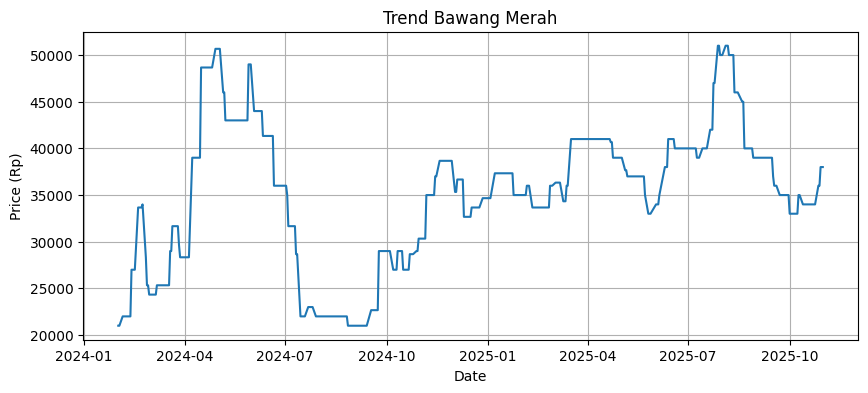

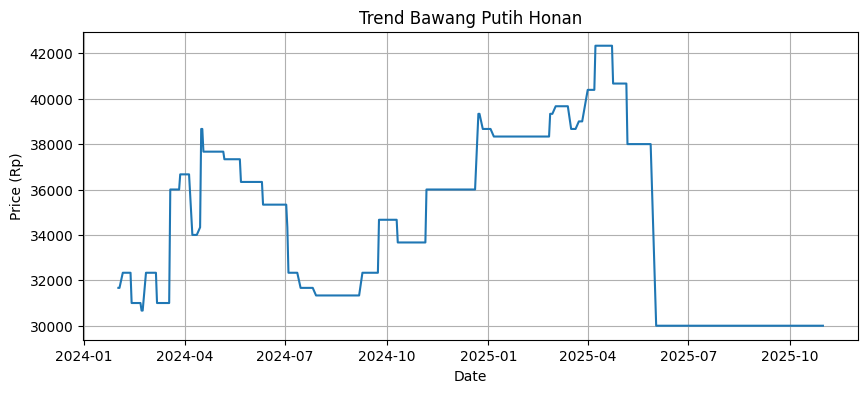

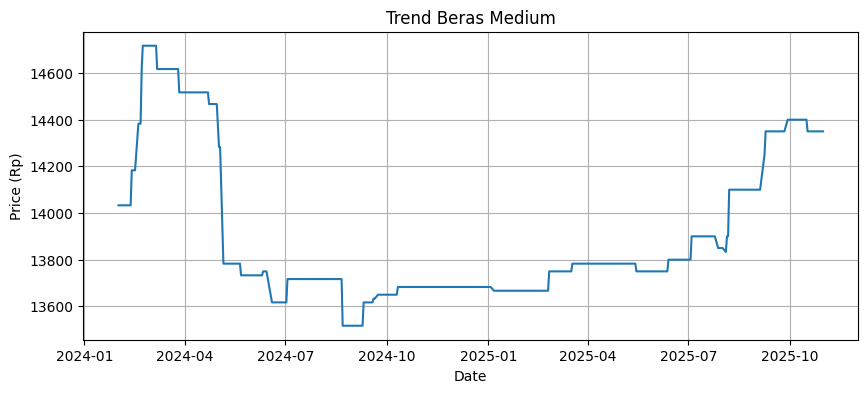

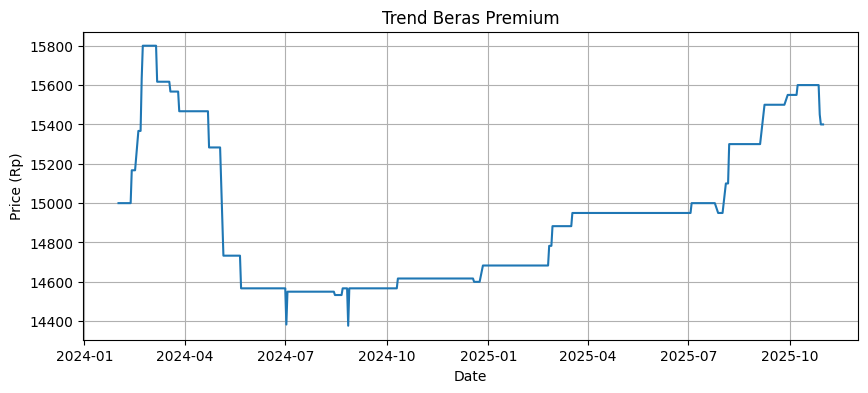

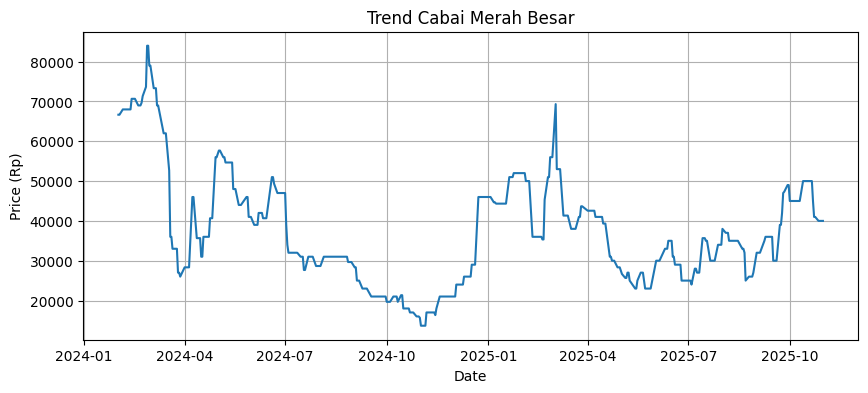

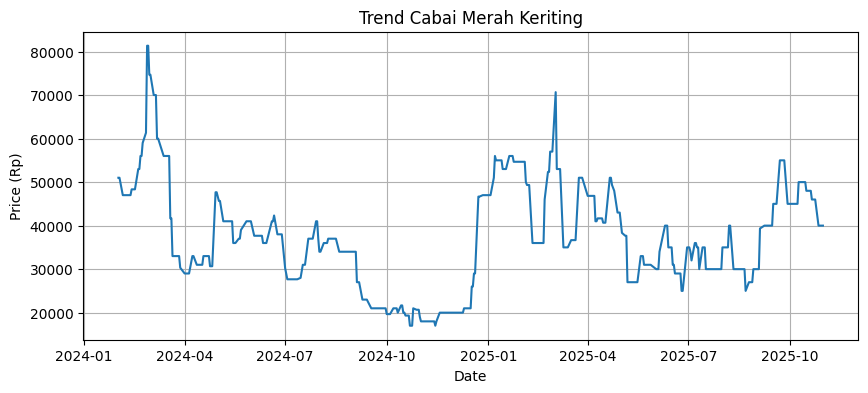

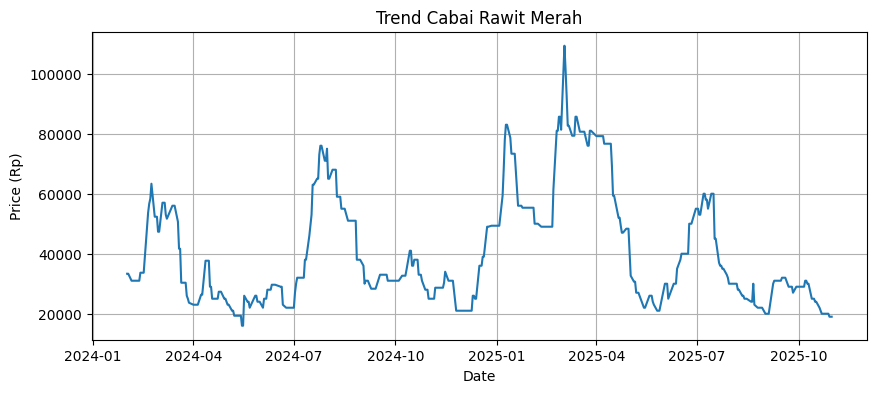

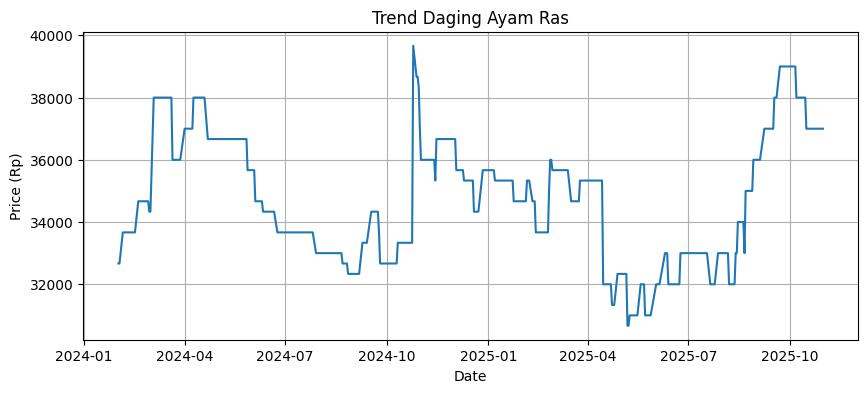

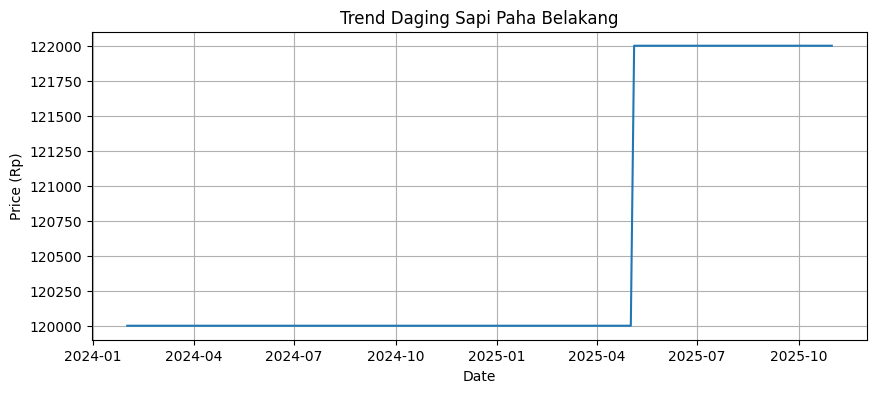

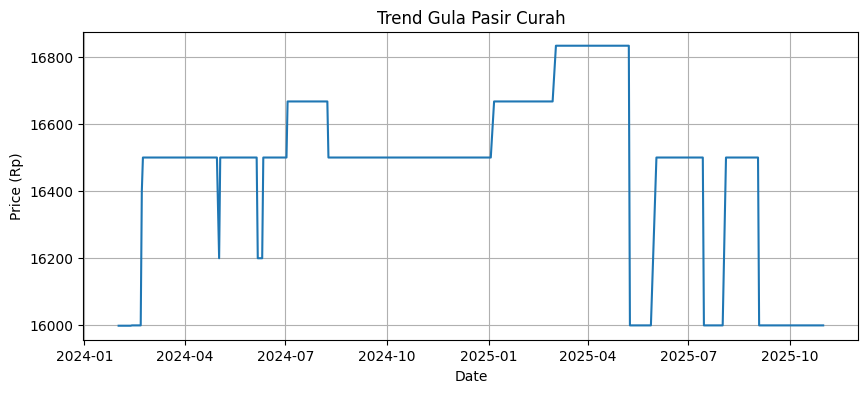

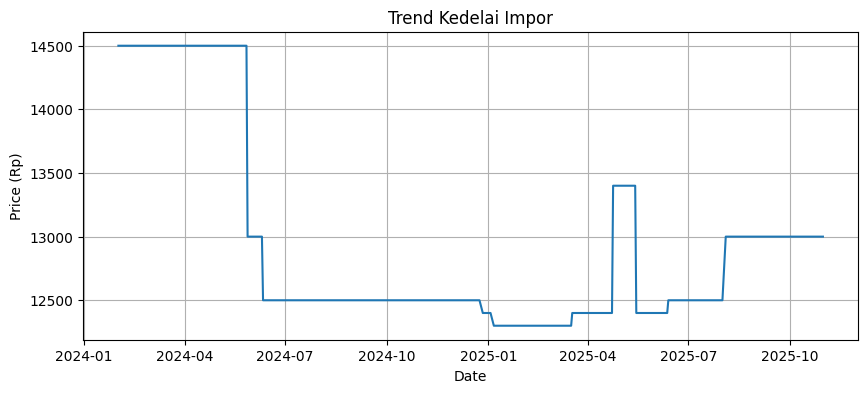

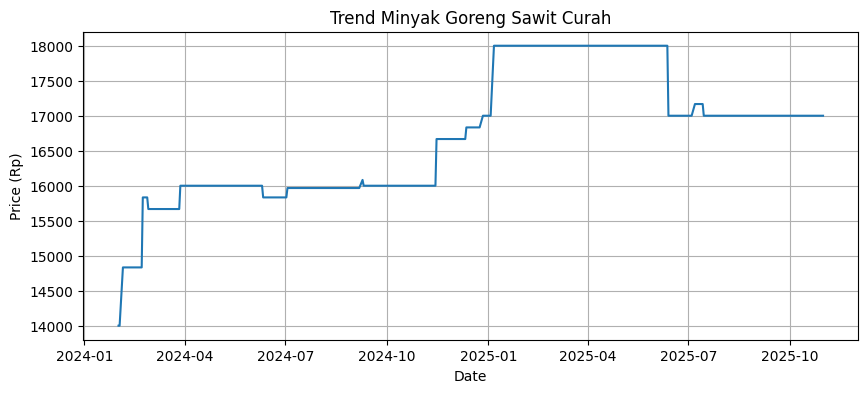

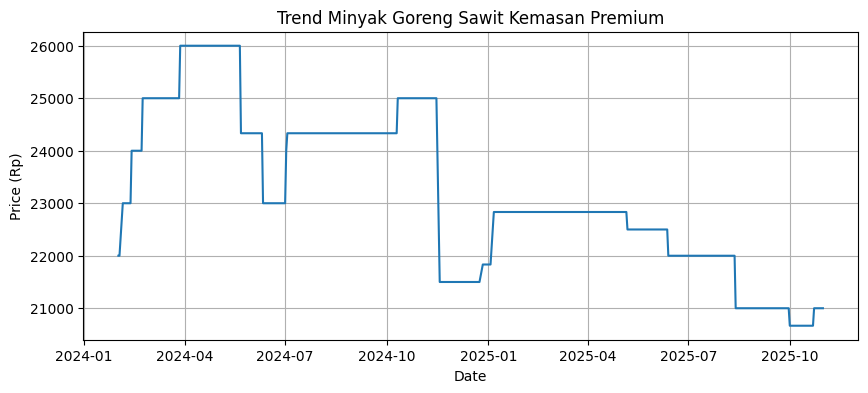

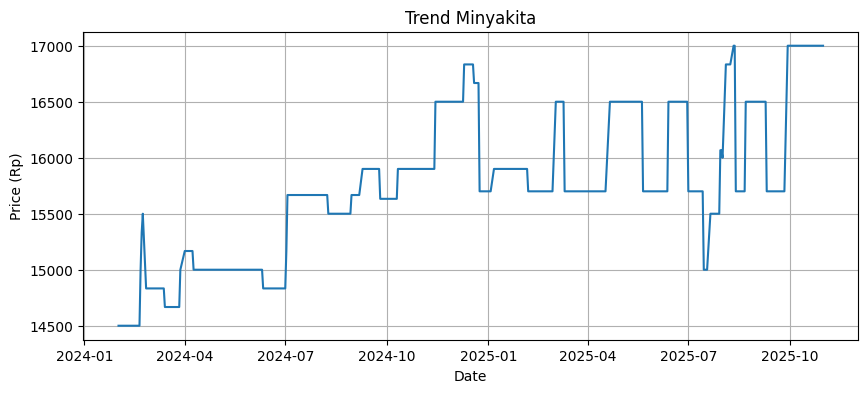

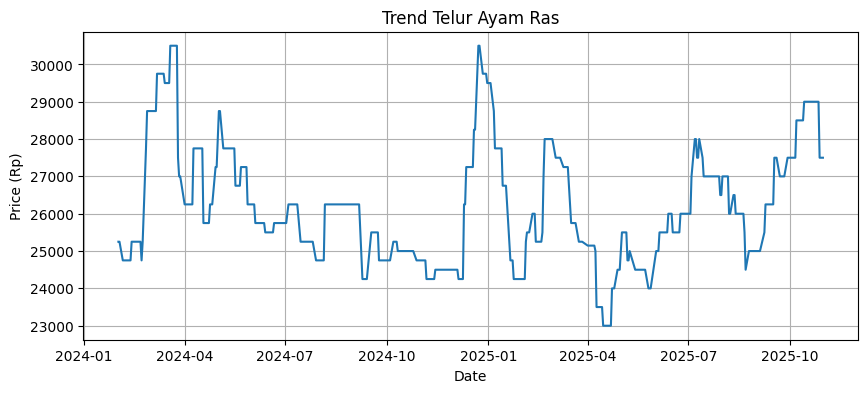

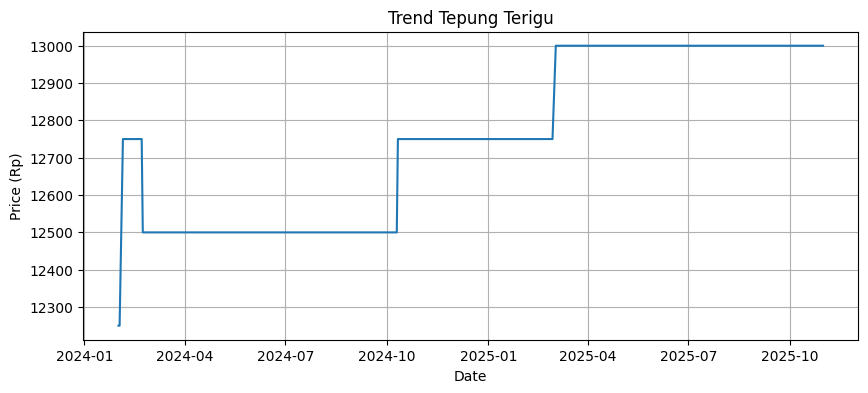

In [4]:
def winsorize_iqr(s: pd.Series, k=3.0) -> pd.Series:
    x = s.values.astype(float)
    q1, q3 = np.nanpercentile(x, 25), np.nanpercentile(x, 75)
    iqr = q3 - q1
    if iqr == 0: return s
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return pd.Series(np.clip(x, lo, hi), index=s.index)

df_clean = df_imp.copy()
for c in df_clean.columns:
    df_clean[c] = winsorize_iqr(df_clean[c])

def plot_series(dates, series, title=""):
    plt.figure(figsize=(10,4))
    plt.plot(dates, series, linewidth=1.5)
    plt.title(title); plt.xlabel("Date"); plt.ylabel("Price (Rp)")
    plt.grid(True); plt.show()

for c in list(df_clean.columns)[:16]:
    plot_series(df_clean.index, df_clean[c], f"Trend {c}")

# Cell 5 - Save

In [5]:
# ============================================================
# 📦 CELL 5: SIMPAN HASIL PREPROCESSING KE CSV
# ============================================================

# Pastikan DataFrame akhir bernama df_wide atau df_final
# (Jika nama Anda berbeda, sesuaikan variabelnya di bawah)

# 1. Sort berdasarkan tanggal (pastikan urut naik)
df_wide = df_wide.sort_index()

# 2. Pastikan tidak ada nilai NaN yang tersisa
print("Jumlah missing values per kolom sebelum disimpan:")
print(df_wide.isna().sum())

# # (Opsional tapi disarankan)
# assert df_wide.isna().sum().sum() == 0, "Masih ada nilai NaN di data akhir!"

# # 3. Simpan hasil clean dataset ke CSV
# output_path = "processed_daily_wide.csv"
# df_wide.to_csv(output_path, index_label="date", float_format="%.2f", encoding="utf-8-sig")

# print(f"\n✅ Dataset harian hasil preprocessing berhasil disimpan ke '{output_path}'")
# print(f"Total baris data: {len(df_wide)}")
# print(f"Rentang tanggal: {df_wide.index.min().date()} s.d. {df_wide.index.max().date()}")
# print(f"Total kolom komoditas: {df_wide.shape[1]}")

Jumlah missing values per kolom sebelum disimpan:
commodity
Bawang Merah                           43
Bawang Putih Honan                     42
Beras Medium                           42
Beras Premium                          42
Cabai Merah Besar                      42
Cabai Merah Keriting                   42
Cabai Rawit Merah                      42
Daging Ayam Ras                        42
Daging Sapi Paha Belakang              42
Gula Pasir Curah                       42
Kedelai Impor                          42
Minyak Goreng Sawit Curah              42
Minyak Goreng Sawit Kemasan Premium    42
Minyakita                              42
Telur Ayam Ras                         42
Tepung Terigu                          42
dtype: int64


In [1]:
!jupyter nbconvert --to script preprocessing_daily_newest.ipynb

[NbConvertApp] Converting notebook preprocessing_daily_newest.ipynb to script
[NbConvertApp] Writing 4223 bytes to preprocessing_daily_newest.py
